# **Face Recognition Using PCA & LDA**


In [49]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

## Generate the Data Matrix and the Label vector


In [50]:
paths = ["datasets/s" + str(i) for i in range(1, 41)]
cnt = 0
Data = np.zeros((400, 10304))
labels = np.zeros((400, 1))
for i in range(40):
    labels[i * 10 : (i + 1) * 10] = i + 1
for path in paths:
    files = os.listdir(path)
    for file in files:
        img = Image.open(path + "/" + file)
        np_img = np.array(img)
        np_img = np_img.flatten()
        Data[cnt] = np_img
        cnt += 1

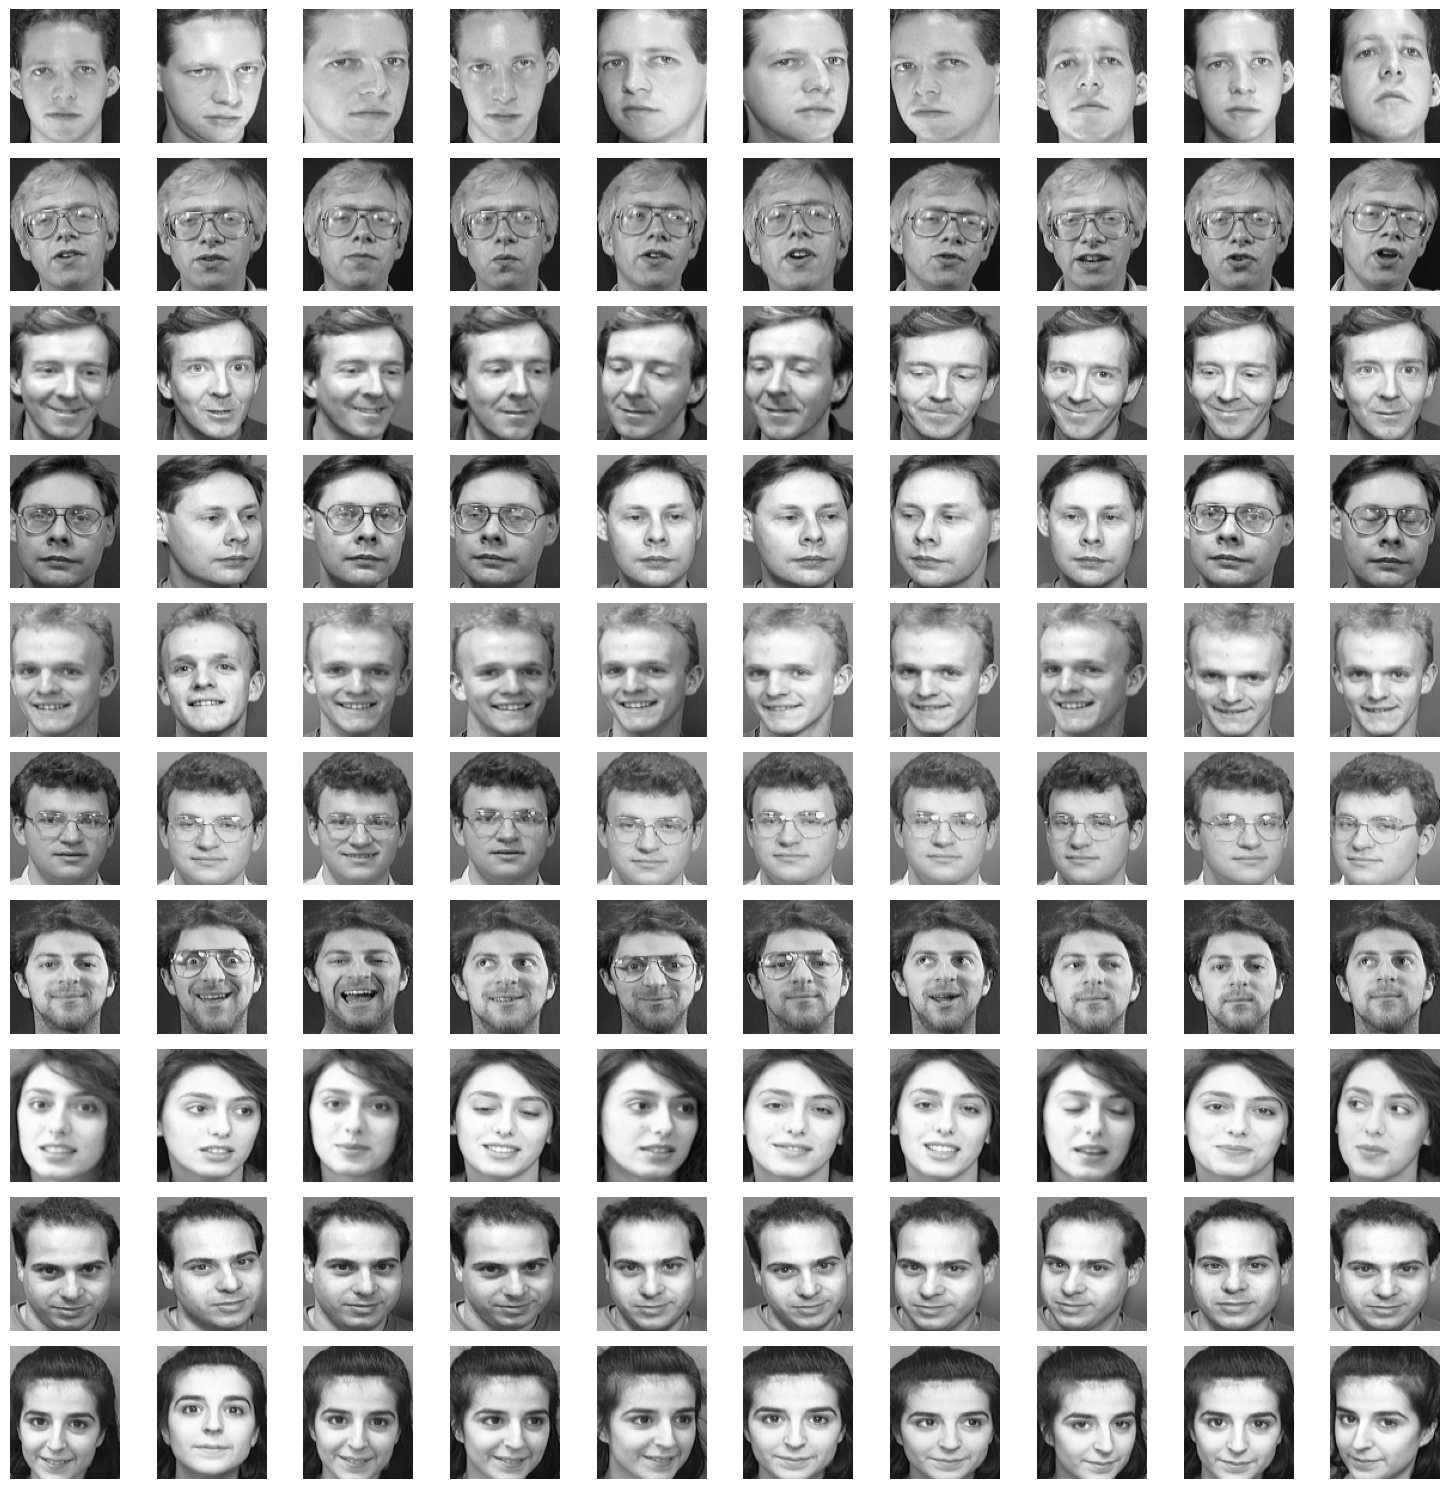

In [51]:
image_height = 112
image_width = 92

fig, axs = plt.subplots(10, 10, figsize=(15, 15))  # Create a grid of 2x2 subplots

# Flatten the array of axes
axs = axs.ravel()

for i in range(100):  # Change this to plot more/fewer images
    image_array = np.reshape(Data[i], (image_height, image_width))
    axs[i].imshow(image_array, cmap="gray")  # Use cmap='gray' for grayscale images
    axs[i].axis("off")  # Turn off axis

plt.tight_layout()
plt.show()

## Splitting The Dataset


In [52]:
X_train = Data[0::2]
X_test = Data[1::2]
y_train = labels[0::2]
y_test = labels[1::2]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(200, 10304)
(200, 10304)
(200, 1)
(200, 1)


## PCA


In [53]:
def get_PCA(X_train, alpha):
    # Compute the mean of the training data
    mean_face = np.mean(X_train, axis=0)
    # subtract the mean from the training data
    X_train_centralized = X_train - mean_face
    # compute the covariance matrix
    cov_matrix = X_train_centralized @ X_train_centralized.T
    cov_matrix /= X_train_centralized.shape[1]
    # compute the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    # sort the eigenvectors descindigly by eigenvalues
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    # restore the original eigenvectors
    eigenfaces = X_train_centralized.T @ eigenvectors
    sum = 0
    no_components = 0
    for i in range(len(eigenvalues)):
        sum += eigenvalues[i]
        no_components += 1
        if sum / np.sum(eigenvalues) >= alpha:
            break

    # project the training data on the eigenfaces
    X_train_pca = X_train_centralized @ eigenfaces[:, :no_components]
    return X_train_pca, mean_face, eigenfaces[:, :no_components]

### Test


In [54]:
def Test(alpha, k):
    X_train_pca, mean_face, eigenfaces = get_PCA(X_train, alpha)
    X_test_centralized = X_test - mean_face
    X_test_pca = X_test_centralized @ eigenfaces
    knn = KNeighborsClassifier(k)
    knn.fit(X_train_pca, y_train.ravel())
    y_pred = knn.predict(X_test_pca)
    accuracy = accuracy_score(y_test, y_pred.ravel())
    return accuracy

## Classifier Tuning for PCA


In [55]:
alphas = [0.8, 0.85, 0.9, 0.95]
k_values = [1, 3, 5, 7, 9]
df = pd.DataFrame(index=alphas, columns=k_values)
for alpha in alphas:
    for k in k_values:
        accuracy = Test(alpha, k)
        df.loc[alpha, k] = accuracy

df

,1,3,5,7,9
0.80,0.925,0.785,0.685,0.605,0.59
0.85,0.925,0.785,0.69,0.625,0.59
0.90,0.925,0.78,0.69,0.625,0.59
0.95,0.925,0.775,0.69,0.62,0.59


# LDA
